## Split slice grappa with in plane acceleration
###### Author: Zimu Huo
###### Date: 05.2022

The slice grappa tries to reduce the total artefact without placing constraints on the intraslice and interslice artifacts. So the artefacts can be arbitrarily large(like vectors pointing in opposite directions can cancel out each other, also called artefact cancellation). The split slice trades interslice artefact with intraslice artefact (lower interslice artefact and higher intraslice artefact) by forming a "correlation matrix" that contrains the interslice leakage to be minimum. 

-------------------------------------------------------------------------
References

    [1] 
    Author:  Stephen F. Cauley et al. 
    Title: Interslice leakage artifact reduction technique for simultaneous multislice acquisitions
    Link: https://pubmed.ncbi.nlm.nih.gov/23963964/

In [3]:
import sys
sys.path.insert(1, '../')
import matplotlib.pyplot as plt
import numpy as np
from scipy import io
import util.simulator as simulate
from util.coil import *
from util.fft import *
import util.mask as undersample
from util.spsg import *

In [4]:
numSlice = 4
R = 4
slice1 = np.load("../lib/slice1_grappa1.npy")
slice2 = np.load("../lib/slice2_grappa1.npy")
slice3 = np.load("../lib/slice3_grappa1.npy")
slice4 = np.load("../lib/slice4_grappa1.npy")
data = np.concatenate((slice1[...,None], slice2[...,None], slice3[...,None], slice4[...,None]), -1)[...,:numSlice]
rawImage = ifft2c(data)
fovHeight, fovWidth, numCoil, _ = rawImage.shape

In [5]:
rawData = np.zeros(rawImage.shape, dtype = complex)
for sli in range (numSlice):
        rawData[:,:,:,sli] = fft2c(rawImage[:,:,:,sli])

In [6]:
cycle = np.arange(0,1,1/numSlice) * 2* np.pi
numAccq = int(numSlice*fovHeight/R)

In [7]:
shift = cycle*numAccq/(2*np.pi)
dataR = fft2c(simulate.multiSliceCAIPI(rawImage, cycle, R))

In [8]:
ncx = 32
ncy = 32
acsshift = cycle*int(numSlice* ncy /R)/(2*np.pi)
acsK = simulate.acs(rawData, (ncy, ncx))
acsIm = ifft2c(acsK)
calib = fft2c(simulate.singleSliceFov(acsIm,acsshift))

In [9]:
recon = spsg(dataR, calib)

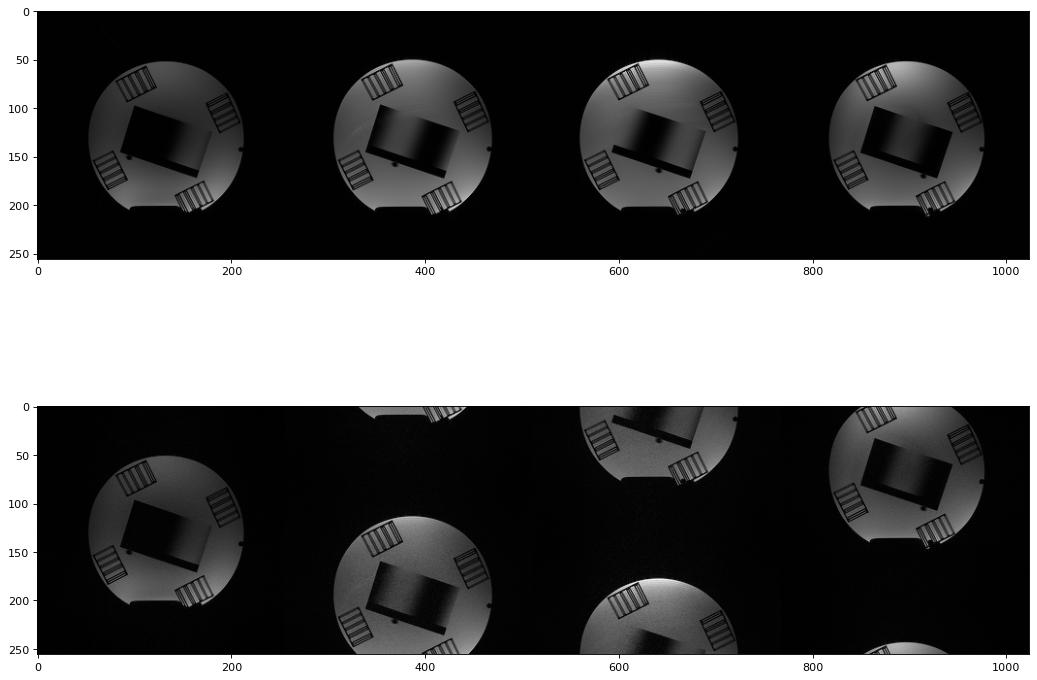

In [11]:
fig = plt.figure(figsize=(16, 12), dpi=80)
plt.subplot(211)
plt.imshow(np.abs(stitch(rsos(rawImage), 1)), cmap = "gray")
plt.subplot(212)
plt.imshow(np.abs(stitch(rsos(ifft2c(recon)),1)), cmap = "gray")